# Final Assignment: Waste Removal

In [1]:
import networkx as nx
from operator import attrgetter, itemgetter
import matplotlib.pyplot as plt
import scipy.stats as sts
import math
import random
import numpy as np

In [2]:
from tqdm import tqdm

In [7]:
class Truck():
    """
    A truck is a vehicle that can move around the map and pick up waste from farms and drop it off at dropoff sites.
    Attributes:
        location (int): The location of the truck on the network.
        id (int): The id of the truck.
        waste_carrying_capacity (int): The maximum amount of waste the truck can carry.
    .waste_currently (int): The amount of waste the truck is currently carrying.
        fuel_capacity (int): The maximum amount of fuel the truck can carry.
    """
    def __init__(self, location, truck_id, waste_carrying_capacity=35, fuel_capacity=115):
        self.id = truck_id
        self.waste_carrying_capacity = waste_carrying_capacity
        self.fuel_capacity = fuel_capacity

        # variables
        self.location = location
        self.waste_currently = 0
        self.fuel_currently = fuel_capacity

        # aggregate variables
        self.total_waste_collected = 0
        self.total_fuel_used = 0
        self.steps_waited = 0

        # other
        self.costs = []
        self.route = [location]
        self.pending_location = None
        
        
    

    def move(self, new_location, sim):
        
        if self.pending_location is not None and self.steps_waited == self.steps_to_wait:
            # if the truck was on the way somewhere else and reached the destination
            self.location = self.pending_location
            self.distance_to_pending_loc = nx.dijkstra_path_length(sim.graph, self.location, self.pending_location, weight='weight')
            self.route_to_pending_loc = nx.dijkstra_path(sim.graph, self.location, self.pending_location, weight='weight')
            self.route.append(self.route_to_pending_loc)
            self.fuel_currently -= self.distance_to_pending_loc
            self.total_fuel_used += self.distance_to_pending_loc

            if self.next_task == 'pick_up_waste':
                # farm with said location
                for farm in sim.farms:
                    if farm.location == self.pending_location:
                        self.pick_up_waste(farm)
            
            elif self.next_task == 'drop_off_waste':
                for dropoff_site in sim.dropoff_sites:
                    if dropoff_site.location == self.pending_location:
                        self.drop_off_waste(dropoff_site)
            else:
                self.refuel(sim)

            self.pending_location = None
            self.steps_waited = 0

        elif self.pending_location is not None and self.steps_waited < self.steps_to_wait:
            # if the truck was on the way somewhere else
            self.steps_waited += 1
        
        else:
            self.distance_to_new_loc = nx.dijkstra_path_length(sim.graph, self.location, new_location, weight='weight')
            self.route_to_new_loc = nx.dijkstra_path(sim.graph, self.location, new_location, weight='weight')
            # ensures that the truck travels 60 miles per step
            if self.check_distance(new_location):
                self.location = new_location
                self.route.append(self.route_to_new_loc)
                
                self.fuel_currently -= self.distance_to_new_loc
                self.total_fuel_used += self.distance_to_new_loc


    def check_distance(self, new_location):
        # truck can only travel 60 kilometers per step
        self.steps_to_wait = (self.distance_to_new_loc // 60 + 1)
        if self.steps_to_wait > 1:
            self.pending_location = new_location
            self.steps_waited += 1
            return False
        return True


    def refuel(self, sim):
        self.fuel_currently -= self.distance_to_hq
        self.fuel_currently = self.fuel_capacity
    

    def pick_up_waste(self, farm):
        farm_waste = farm.waste_amount
        waste_possible_to_carry = self.waste_carrying_capacity - self.waste_currently
        picked_up_waste = min(farm_waste, waste_possible_to_carry)
        farm.waste_amount -= picked_up_waste
        farm.total_waste_collected += picked_up_waste

        self.waste_currently += picked_up_waste
        self.total_waste_collected += picked_up_waste

    def drop_off_waste(self, dropoff_site):
        self.waste_to_drop = self.waste_carrying_capacity
        dropoff_site.total_waste_dropped_off += self.waste_to_drop
        self.waste_currently = 0

    def check_fuel(self, new_location, sim):
        
        self.distance_to_new_loc = nx.dijkstra_path_length(sim.graph, new_location, self.location)
        self.distance_to_hq = max(nx.dijkstra_path_length(sim.graph, new_location, sim.hq.location), nx.shortest_path_length(sim.graph, self.location, sim.hq.location))
        distance = self.distance_to_new_loc + self.distance_to_hq

        if distance <= self.fuel_currently:
            return True
        return False


    def check_waste(self):
        if int(self.waste_currently) == int(self.waste_carrying_capacity):
            return False
        return True

    def __repr__(self, sim) -> str:
        # check what location is
        if self.location == sim.hq.location:
            return f'🚚 Truck {self.id} at HQ with {self.waste_carrying_capacity - self.waste_currently} waste carrying capacity left and fuel status of {self.fuel_currently}.'
        elif self.location in sim.farms:
            return f'🚚 Truck {self.id} at Farm {self.location} with {self.waste_carrying_capacity - self.waste_currently} waste carrying capacity left and fuel status of {self.fuel_currently}.'
        elif self.location in sim.dropoff_sites:
            return f'🚚 Truck {self.id} at Dropoff Site {self.location} with {self.waste_carrying_capacity - self.waste_currently} waste carrying capacity left and fuel status of {self.fuel_currently}.'


In [8]:

class Farm():
    """
    A farm that generates waste.
    Attributes:
        location: the location of the farm on the network.
    """
    def __init__(self, location):
        self.location = location
        self.waste_amount = 0
        self.total_waste_generated = 0
        self.total_waste_collected = 0
        self.accumulating_waste = 0

    def add_waste(self, amount):
        # add waste probabilistically
        self.waste_amount += amount
        self.total_waste_generated += amount

    def accumulate_waste(self, amount):
        self.accumulating_waste += amount

    def __repr__(self) -> str:
        return f'🏡 Farm {self.location} with {self.waste_amount} waste.'

class DropoffSite():
    """
    The dropoff site where trucks drop off waste.
    Attributes:
        location: the location of the dropoff site on the network.
    """
    def __init__(self, location):
        self.location = location
        self.total_waste_dropped_off = 0

    def __repr__(self) -> str:
        return f'🗑 Dropoff site {self.location} with {self.total_waste_dropped_off} waste dropped off.'

class Headquarters():
    """
    The headquarters where trucks refuel.
    Attributes:
        location: the location of the headquarters on the network.
    """
    def __init__(self, location):
        self.location = location


class WasteSystemSimulation():
    """
    Simulates a waste collection system with farms, trucks, and dropoff sites.
    Attributes:
        num_farms: the number of farms in the system.
        num_dropoff_sites: the number of dropoff sites in the system.
        num_trucks: the number of trucks in the system.
        waste_gen_lambda: the lambda parameter for the Poisson distribution for waste generation.
        distance_lambda: the lambda parameter for the Poisson distribution for distance between nodes.
        strategy: the strategy for the trucks to use.
        change_probability: the probability that a truck will randomly select a node if following the randomness strategy.


    """

    def __init__(self, num_farms = 10, num_dropoff_sites=3, num_trucks=2, 
                   waste_gen_lambda=20.14, distance_lambda=20, strategy='greedy',
                   change_probability=0.1, test_type=None, vis=False):
        self.waste_gen_lambda = waste_gen_lambda
        self.distance_lambda = distance_lambda
        self.strategy = strategy
        self.change_probability = change_probability
        self.test_type = test_type

        self.num_farms = int(num_farms)
        self.num_dropoff_sites = int(num_dropoff_sites)
        self.num_trucks = int(num_trucks)
        self.vis = vis

    def initialize(self):
        
        self.n_nodes = self.num_farms + self.num_dropoff_sites + 1
        self.num_nodes = self.n_nodes

        # random fully-connected graph with fram + hq + dropoff site nodes.
        self.graph = nx.barabasi_albert_graph(self.n_nodes, 2, seed=42)

        self.edge_labels = {}
        for edge in self.graph.edges:
                weight = sts.poisson.rvs(self.distance_lambda)  
                # save the weight in the edge label
                self.graph.edges[edge]['weight'] = weight
                self.edge_labels[edge] = round(weight, 0)  
        self.pos = nx.spring_layout(self.graph)             

        # generate a series of random numbers in the length of the number of nodes - 1
        nodes = np.random.choice(range(0, int(self.n_nodes)), int(self.n_nodes), replace=False)
        
        # pick the most connected node to be hq
        hq_loc = max(self.graph.degree, key=itemgetter(1))[0]
        self.hq = Headquarters(hq_loc)

        # remove the hq_loc from the lst
        nodes = np.delete(nodes, np.where(nodes == hq_loc))

        # assign the first num_farms nodes to be farm locations, and the next num_dropoff_sites to be dropoff site locations
        farm_locs = nodes[:self.num_farms]
        dropoff_locs = nodes[self.num_farms:]

        self.farms = []
        for loc in farm_locs:
            farm = Farm(loc)
            self.farms.append(farm)

        self.dropoff_sites = []
        for loc in dropoff_locs:
            dropoff = DropoffSite(loc)
            self.dropoff_sites.append(dropoff)
        
        self.trucks = []
        for t in range(self.num_trucks):
            truck = Truck(hq_loc, t)
            self.trucks.append(truck)

        self.step_counter = 0
        self.steps_until_full_coverage = 0

        self.visited_set = set()
        self.costs = []
        
        self.total_waste_generated = []
        self.total_waste_collected = []
        self.total_waste_dropped_off = []

        self.total_current_waste = []
        self.total_waste_carried = []

        self.total_fuel_used = []

    def observe(self, vis=False):
        vis = self.vis

        print(f'⏰ Step {self.step_counter}')
        print(f'🏣 Headquarters at {self.hq.location}')
        # visualize the graph
        if vis:
            nx.draw(self.graph, with_labels=True, pos=self.pos)
            # draw edge labels
            nx.draw_networkx_edge_labels(self.graph, pos=self.pos, edge_labels=self.edge_labels, label_pos=0.7, font_size=10)
            plt.show()

        # print out truck location
        for t in self.trucks:
            print(t.__repr__(self))

        # print out waste at each farm
        for f in self.farms:
            print(f)

        for d in self.dropoff_sites:
            print(d)

    def update_farms(self):
        for f in self.farms:
            # generate a poisson random variable for the amount of trash generated per hour
            f.accumulate_waste(sts.poisson(self.waste_gen_lambda/24).rvs())
            if self.step_counter % 24 == 0:
                f.add_waste(f.accumulating_waste)
                f.accumulating_waste = 0

    def choose_next_location(self, t):
        # farm with the most trash
        self.random_farm = False
        self.random_dropoff = False
        max_waste_farm = max(self.farms, key=attrgetter("waste_amount"))

        # find the nearest dropoff site
        for d in self.dropoff_sites:
            d.distance = nx.dijkstra_path_length(self.graph, t.location, d.location, weight='weight')
        nearest_dropoff_site = min(self.dropoff_sites, key=attrgetter("distance"))

        if self.strategy == 'greedy':
            next_farm = max_waste_farm
            next_dropoff_site = nearest_dropoff_site
        elif self.strategy == 'randomness':
            if random.random() < self.change_probability:
                # choose next location randomly from farms and dropoff sites
                next_location = random.choice(self.farms + self.dropoff_sites)
                if isinstance(next_location, Farm):
                    next_farm = next_location
                    next_dropoff_site = nearest_dropoff_site
                    self.random_farm = True
                    self.random_dropoff = False
                elif isinstance(next_location, DropoffSite):
                    next_farm = max_waste_farm
                    next_dropoff_site = next_location
                    self.random_dropoff = True
                    self.random_farm = False

            else:
                next_farm = max_waste_farm
                next_dropoff_site = nearest_dropoff_site

        return next_farm, next_dropoff_site

    def update_trucks(self):
        
        for t in self.trucks:

            next_farm, next_dropoff_site = self.choose_next_location(t)

            # if there is enough fuel and some waste capacity left, move to the farm with the most waste
            if t.check_fuel(next_farm.location, self) and t.check_waste() and self.random_dropoff == False and self.random_farm == False:
                t.next_task = 'pick_up_waste'
                t.move(next_farm.location, self)
                
                # if the truck can get there in one hour, schedule it for now
                if t.steps_to_wait <= 1:
                    t.pick_up_waste(next_farm)
                    self.visited_set.add(next_farm.location)        

            # if there is enough fuel but no waste capacity left, move to the nearest dropoff site
            elif t.check_fuel(next_dropoff_site.location, self) and not t.check_waste():
                t.next_task = 'drop_off_waste'
                t.move(next_dropoff_site.location, self)
            
                if t.steps_to_wait <= 1:
                    t.drop_off_waste(next_dropoff_site)

            # otherwise, there is not enough fuel, so move to the hq and refuel
            elif not t.check_fuel(next_dropoff_site.location, self):
                t.next_task = 'refuel'
                t.move(self.hq.location, self)
                if t.steps_to_wait <= 1:
                    t.refuel(self)

    def update_metrics(self):
        self.total_waste_generated.append(self.get_total_waste_generated())
        self.total_waste_collected.append(self.get_total_waste_collected())
        self.total_waste_dropped_off.append(self.get_total_waste_dropped_off())

        self.total_current_waste.append(self.get_total_current_waste())
        self.total_fuel_used.append(self.get_total_fuel_used())

        self.total_waste_carried.append(self.get_total_waste_carried())

        if self.visited_set != set(f.location for f in self.farms):
            self.steps_until_full_coverage += 1
            # average number of edges per node in graph
        self.step_counter += 1
        self.costs.append(self.empirical_cost())
    

    def update(self):

        self.update_farms()
        self.update_trucks()
        self.update_metrics()

        

    def get_total_current_waste(self):
        return sum([f.waste_amount for f in self.farms])
    
    def theoretical_cost(self):
        # Calculation based on theoretical analysis
        average_edge_num = 2 * self.graph.number_of_edges() / self.graph.number_of_nodes()
        avg_shortest_path_length = 1 / (self.num_nodes * (self.num_nodes - 1)) * math.log(self.num_nodes)/math.log(average_edge_num)
        velocity = 60
        self.estimated_waste = self.step_counter * self.num_nodes * self.waste_gen_lambda / 24
        self.estimated_cost = 2 * avg_shortest_path_length * velocity - self.estimated_waste 
        
        if self.strategy == 'randomness':
            self.estimated_cost += self.change_probability * avg_shortest_path_length
        
        return self.estimated_cost
    

    def empirical_cost(self, metric='cost'):
        if metric == 'waste':
            return sum([f.total_waste_generated for f in self.farms])
        elif metric == 'fuel':
            return sum([t.total_fuel_used for t in self.trucks])
        elif metric == 'steps':
            return self.steps_until_full_coverage
        elif metric == 'dropped_off':
            return sum([d.total_waste_dropped_off for d in self.dropoff_sites])
        elif metric == 'cost':
            avg_shortest_path_length = nx.average_shortest_path_length(self.graph, weight='weight')
            velocity = 60
            waste_produced = sum([f.total_waste_generated for f in self.farms])
            return 2 * avg_shortest_path_length * velocity - waste_produced
        

    def simulate(self, steps):
        self.initialize()
        for i in range(steps):
            self.update()

    def get_total_waste_generated(self):
        return sum([f.total_waste_generated for f in self.farms])
    
    def get_total_fuel_used(self):
        return sum([t.total_fuel_used for t in self.trucks])
    
    def get_total_waste_collected(self):
        return sum([t.total_waste_collected for t in self.trucks])
    
    def get_total_waste_dropped_off(self):
        return sum([d.total_waste_dropped_off for d in self.dropoff_sites])


    def get_total_waste_carried(self):
        return sum([t.waste_currently for t in self.trucks])
    
    def get_metrics(self):
        metrics_dict = {}
        metrics_dict['total_waste_generated'] = self.total_waste_generated
        metrics_dict['total_fuel'] = self.total_fuel_used
        metrics_dict['total_waste_collected'] = self.total_waste_collected
        metrics_dict['total_dropped_off'] = self.total_waste_dropped_off
        metrics_dict['total_current_waste'] = self.total_current_waste
        metrics_dict['total_carried_waste'] = self.total_waste_carried

        return metrics_dict



        

    



## Test Cases

### Basic waste generation and collection

The test case below demonstrates that the basic functionality of the simulation (picking up waste and dropping it off at the dump) works as expected. This test case also ensures there is no phantom waste generation or depletion.

In [9]:
sim = WasteSystemSimulation(num_farms=2, num_trucks=1, num_dropoff_sites=1)

sim.initialize()

for _ in range(25):
    sim.update()

# make sure to run for long enough so that all farms are visited
for _ in range(1000):
    sim.update_trucks()
    sim.update_metrics()

metrics_dict = sim.get_metrics()

# assert that total waste generated is equal to total waste collected
assert metrics_dict['total_waste_generated'][-1] == metrics_dict['total_waste_collected'][-1]

# assert that total waste dropped off and currently on trucks is equal to total waste collected
assert metrics_dict['total_dropped_off'][-1] + metrics_dict['total_carried_waste'][-1] == metrics_dict['total_waste_collected'][-1]

# assert that the current waste has been collected
assert metrics_dict['total_current_waste'][-1] == 0 


### More in-depth metrics

#### Simulation

This simulation generates an ongoing simulation with 2 farms, one dropoff site, and one truck. It is supposed to show the general dynamics in a simplified system.

In [10]:
steps = 50
farm_waste_gen_test = WasteSystemSimulation(num_farms=2, num_dropoff_sites=1, num_trucks=1)
farm_waste_gen_test.initialize()

f1 = farm_waste_gen_test.farms[0]
f2 = farm_waste_gen_test.farms[1]

farm_waste = {'accumulating_1': [0], 'total_1': [0], 'accumulating_2': [0], 'total_2': [0], 'truck_at_farm_1': [-5], 'truck_at_farm_2': [-5]}
dropoff_waste = {'total' : [0], 'truck_at_dropoff': [-5]}
hq = {'truck_at_hq': [-1]}

fuel_over_time = [farm_waste_gen_test.trucks[0].fuel_capacity]
waste_carried_over_time = [farm_waste_gen_test.trucks[0].waste_currently]


truck_loc = [farm_waste_gen_test.trucks[0].location]

# The updates below gather the locations of the truck over the course of the simulation
for i in range(steps):
    farm_waste_gen_test.update()
    fuel_over_time.append(farm_waste_gen_test.trucks[0].fuel_currently)
    waste_carried_over_time.append(farm_waste_gen_test.trucks[0].waste_currently)

    if farm_waste_gen_test.trucks[0].location == f1.location:
        
        farm_waste['truck_at_farm_1'].append(-1)
        farm_waste['truck_at_farm_2'].append(-5)
        dropoff_waste['truck_at_dropoff'].append(-5)
        hq['truck_at_hq'].append(-5)

    elif farm_waste_gen_test.trucks[0].location == f2.location:
        
        farm_waste['truck_at_farm_1'].append(-5)
        farm_waste['truck_at_farm_2'].append(-1)
        dropoff_waste['truck_at_dropoff'].append(-5)
        hq['truck_at_hq'].append(-5)

    elif farm_waste_gen_test.trucks[0].location == farm_waste_gen_test.dropoff_sites[0].location:
        farm_waste['truck_at_farm_1'].append(-5)
        farm_waste['truck_at_farm_2'].append(-5)
        dropoff_waste['truck_at_dropoff'].append(-1)
        hq['truck_at_hq'].append(-5)

    elif farm_waste_gen_test.trucks[0].location == farm_waste_gen_test.hq.location:
        farm_waste['truck_at_farm_1'].append(-5)
        farm_waste['truck_at_farm_2'].append(-5)
        dropoff_waste['truck_at_dropoff'].append(-5)
        hq['truck_at_hq'].append(-1)

    else:
        farm_waste['truck_at_farm_1'].append(-1)
        farm_waste['truck_at_farm_2'].append(-5)
        dropoff_waste['truck_at_dropoff'].append(-5)
        hq['truck_at_hq'].append(-5)

    farm_waste['accumulating_1'].append(f1.accumulating_waste)
    farm_waste['total_1'].append(f1.waste_amount)
    farm_waste['accumulating_2'].append(f2.accumulating_waste)
    farm_waste['total_2'].append(f2.waste_amount)
   


#### Test 1: Truck waste versus position over time

The code below plots the waste varried the by truck versus its position. It can be seen that the truck remains at the farm with the most waste (or switches positions between farms with the most waste) until its carrying capacity is filled. After the carrying capacity is reached, the truck moves to the dropoff site, as represented by the green dot at the bottom of the graph. The truck then returns to the farm with the most waste and repeats the process.

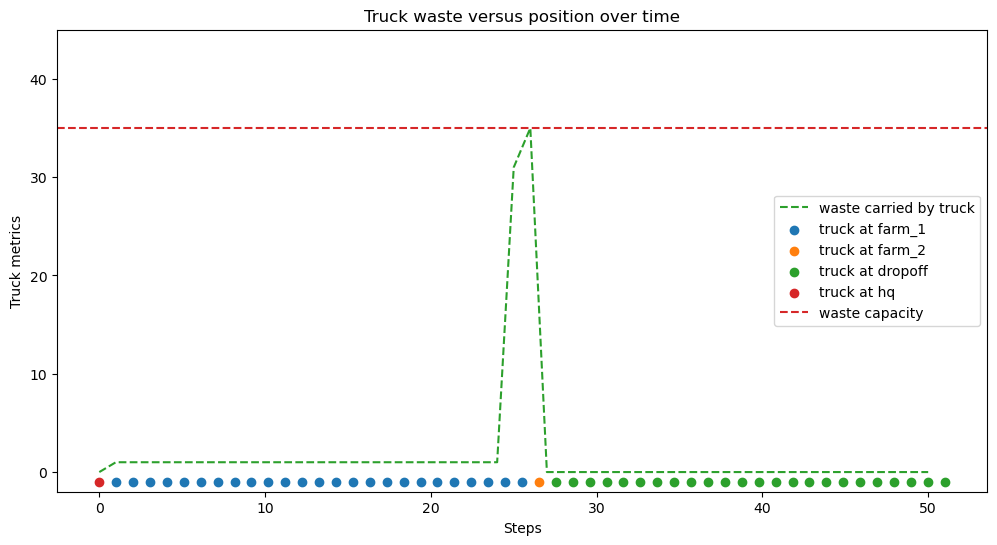

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(waste_carried_over_time, label='waste carried by truck', color='C2',linestyle='--')


plt.scatter(np.linspace(0, steps + 1, steps + 1), farm_waste['truck_at_farm_1'], label='truck at farm_1', color='C0')
plt.scatter(np.linspace(0, steps + 1, steps + 1), farm_waste['truck_at_farm_2'], label='truck at farm_2', color='C1')
plt.scatter(np.linspace(0, steps + 1, steps + 1), dropoff_waste['truck_at_dropoff'], label='truck at dropoff', color='C2')
plt.scatter(np.linspace(0, steps + 1, steps + 1), hq['truck_at_hq'], label='truck at hq', color='C3')


plt.axhline(y=farm_waste_gen_test.trucks[0].waste_carrying_capacity, label='waste capacity', color='C3', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Truck metrics')
plt.title('Truck waste versus position over time')
plt.legend()
plt.ylim(-2, (max(waste_carried_over_time)) + 10)
plt.show()


#### Test 2: Truck fuel versus position over time

Here, it can be seen that the truck's fuel capacity depletes as it travels from farm to farm, starting off with the complete fuel capacity and then depleting as it travels around the farm. Once the truck would not be able to travel to a location while being able to travel to headquarters, the truck is sent to refuel, reaching its fuel capacity once again. Additionally, while a truck remains at a farm, as signified by the dots of the same color at the bottom of the graph, the truck's fuel capacity does not decrease.

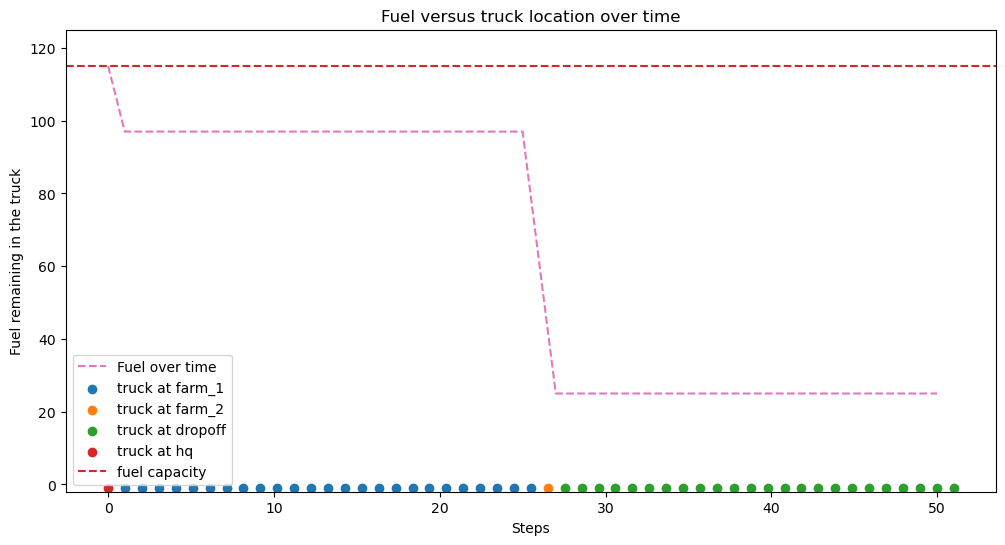

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(fuel_over_time, label='Fuel over time', color='C6', linestyle='--')
plt.scatter(np.linspace(0, steps + 1, steps + 1), farm_waste['truck_at_farm_1'], label='truck at farm_1', color='C0')
plt.scatter(np.linspace(0, steps + 1, steps + 1), farm_waste['truck_at_farm_2'], label='truck at farm_2', color='C1')
plt.scatter(np.linspace(0, steps + 1, steps + 1), dropoff_waste['truck_at_dropoff'], label='truck at dropoff', color='C2')
plt.scatter(np.linspace(0, steps + 1, steps + 1), hq['truck_at_hq'], label='truck at hq', color='C3')


plt.xlabel('Steps')
plt.ylabel('Fuel remaining in the truck')
plt.axhline(y=farm_waste_gen_test.trucks[0].fuel_capacity, label='fuel capacity', color='C3', linestyle='--')
plt.title('Fuel versus truck location over time')
plt.legend()
plt.ylim(-2, max(max(farm_waste['total_1']), max(farm_waste['total_2']), max(fuel_over_time)) + 10)
plt.show()


#### Test 3: Farm waste generation over time

This test case goes hand-in-hand with the basic test case from above. As was shown, there is no waste mysteriously appearing or disappearing in the closed system. This test case instead serves to show the variation of the waste at a farm. The total waste at a farm represents the waste that is both accumulating and is posted at a farm. The posted waste is the only waste the truck can access and pick up. This serves to show the veracity of an actual waste removal process. 

As can be seen, once the waste is posted at the end of the 24-hour accumulation period, and if the truck is at the farm, the total waste depletes right away, signifying that the truck has picked up the waste. If the truck is not at the farm and it is not time to post the waste, the posted waste remains the same while the total waste keeeps increasing (due to the accumulated waste). 

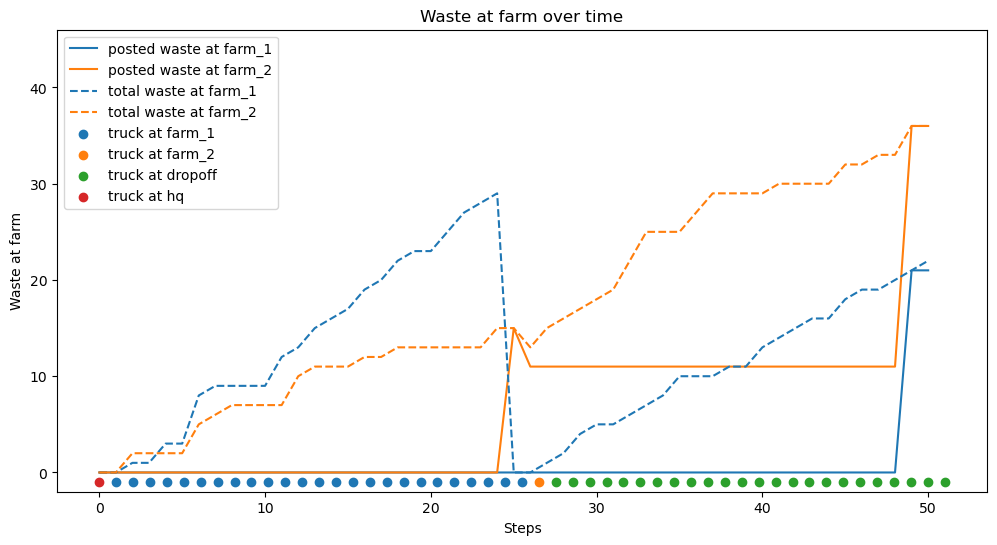

In [13]:

plt.figure(figsize=(12, 6))
plt.plot(farm_waste['total_1'], label='posted waste at farm_1', color='C0')
plt.plot(farm_waste['total_2'], label='posted waste at farm_2', color='C1')
plt.plot(np.sum([farm_waste['total_1'], farm_waste['accumulating_1']], axis=0), label='total waste at farm_1', color='C0', linestyle='--')
plt.plot(np.sum([farm_waste['total_2'], farm_waste['accumulating_2']], axis=0), label='total waste at farm_2', color='C1', linestyle='--')


plt.xlabel('Steps')
plt.ylabel('Waste at farm')


plt.scatter(np.linspace(0, steps + 1, steps + 1), farm_waste['truck_at_farm_1'], label='truck at farm_1', color='C0')
plt.scatter(np.linspace(0, steps + 1, steps + 1), farm_waste['truck_at_farm_2'], label='truck at farm_2', color='C1')
plt.scatter(np.linspace(0, steps + 1, steps + 1), dropoff_waste['truck_at_dropoff'], label='truck at dropoff', color='C2')
plt.scatter(np.linspace(0, steps + 1, steps + 1), hq['truck_at_hq'], label='truck at hq', color='C3')



plt.title('Waste at farm over time')
plt.legend()
plt.ylim(-2, max(max(farm_waste['total_1']), max(farm_waste['total_2'])) + 10)

plt.show()

## Exploration of parameter space

In [14]:
def update_old_dict(old_dict, new_dict, another_key):

    for k, v in new_dict.items():
        if k not in old_dict[another_key]:
            old_dict[another_key][k] = v

        else:
            old_metrics = old_dict[another_key][k]
            new_metrics = np.mean([old_metrics, v], axis=0)
            old_dict[another_key][k] = new_metrics

    return old_dict


def get_plotting_helpers(dictionary):
    """
    Returns the first key, metrics, and metrics_colors for plotting.
    """

    first_key = list(dictionary.keys())[0]
    metrics = list(dictionary[first_key].keys())

    metrics_colors = {}
    for _ in range(len(metrics)):
        metrics_colors[metrics[_]] = 'C' + str(_)
    
    return first_key, metrics, metrics_colors


def plot_metrics_for_varied_params(dictionary, title, xlabel, ylabel):
    """
    Plots the metrics for varied parameters to explore the parameter space.
    """
    plt.figure(figsize=(12, 6))

    first_key, metrics, metrics_colors = get_plotting_helpers(dictionary)

    for varied_parameter in dictionary.keys():

        for metric in dictionary[varied_parameter].keys():

            if varied_parameter == first_key:
                plt.plot(varied_parameter, dictionary[varied_parameter][metric][-1], 'o', label=metric, c=metrics_colors[metric])
            else:
                plt.plot(varied_parameter, dictionary[varied_parameter][metric][-1], 'o', c=metrics_colors[metric])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()





### Number of farms

In [15]:
from tqdm import tqdm
n_farms = np.linspace(10, 100, 5)

trials = 10
n_farms_dict = {}

    
for f in (n_farms):

    n_farms_dict[f] = {}

    for t in tqdm(range(trials)):
        waste_sim = WasteSystemSimulation(num_farms=f)
        waste_sim.simulate(1000)
        metrics = waste_sim.get_metrics()

        n_farms_dict = update_old_dict(n_farms_dict, metrics, f)


        

 70%|███████   | 7/10 [03:49<01:38, 32.76s/it]


KeyboardInterrupt: 

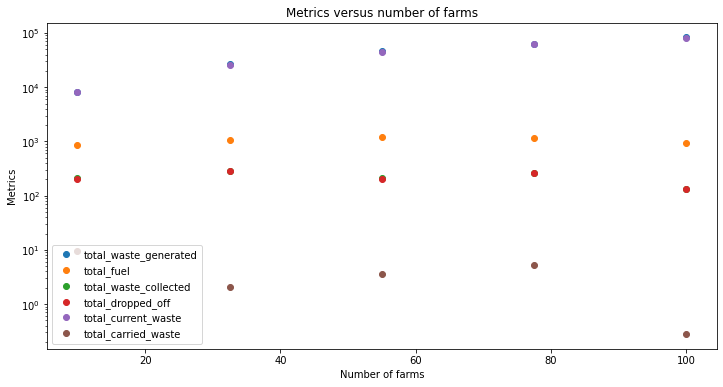

In [ ]:
plot_metrics_for_varied_params(n_farms_dict, 'Metrics versus number of farms', 'Number of farms', 'Metrics')

### Number of trucks

In [ ]:
from tqdm import tqdm
n_trucks = np.linspace(1, 10, 5)

trials = 10
n_trucks_dict = {}
    
for tr in (n_trucks):

    n_trucks_dict[tr] = {}
    
    for _ in tqdm(range(trials)):
        waste_sim = WasteSystemSimulation(num_trucks=tr)
        waste_sim.simulate(1000)
        metrics = waste_sim.get_metrics()

        n_trucks_dict = update_old_dict(n_trucks_dict, metrics, tr)

        

100%|██████████| 10/10 [01:48<00:00, 10.83s/it]


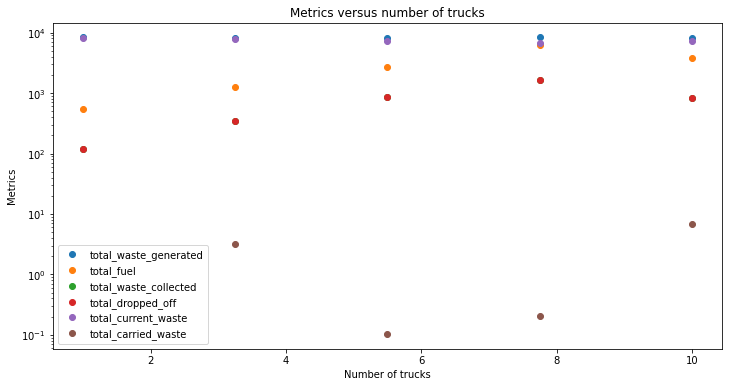

In [ ]:
plot_metrics_for_varied_params(n_trucks_dict, 'Metrics versus number of trucks', 'Number of trucks', 'Metrics')

### Number of dropoff sites

In [ ]:
n_dropoff_sites = np.linspace(1, 10, 5)

trials = 10
n_dropoff_sites_dict = {}

for drop in (n_dropoff_sites):

    n_dropoff_sites_dict[drop] = {}

    for _ in tqdm(range(trials)):


        waste_sim = WasteSystemSimulation(num_dropoff_sites=drop)
        waste_sim.simulate(1000)
        metrics = waste_sim.get_metrics()
        
        n_dropoff_sites_dict = update_old_dict(n_dropoff_sites_dict, metrics, drop)


        
        

100%|██████████| 10/10 [02:08<00:00, 12.81s/it]


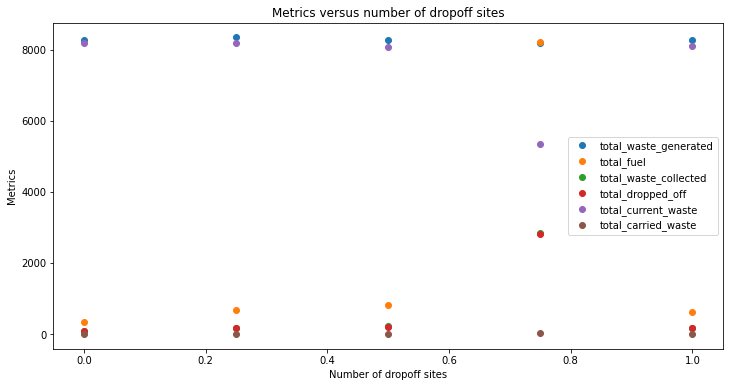

In [ ]:
plot_metrics_for_varied_params(n_dropoff_sites_dict, 'Metrics versus number of dropoff sites', 'Number of dropoff sites', 'Metrics')

### Random approach: Change probability

In [ ]:
change_probabilities = np.linspace(0, 1, 5)

trials = 10
change_probabilities_dict = {}



for cp in (change_probabilities):

    change_probabilities_dict[cp] = {}

    for _ in tqdm(range(trials)):

        waste_sim = WasteSystemSimulation(change_probability=cp)
        waste_sim.simulate(1000)
        metrics = waste_sim.get_metrics()
        
        n_dropoff_sites_dict = update_old_dict(change_probabilities_dict, metrics, cp)


        


100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


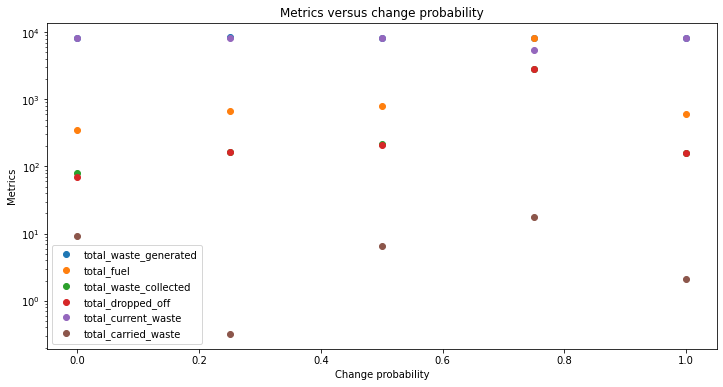

In [ ]:
plot_metrics_for_varied_params(change_probabilities_dict, 'Metrics versus change probability', 'Change probability', 'Metrics')

## Strategy Comparison

In [ ]:
n_farms = 11
n_dropoff_sites = 5
n_trucks = 5

trials = 100
greedy_dict = {}
moderately_random_dict = {}
extremely_random_dict = {}

for _ in tqdm(range(trials)):
    greedy_dict[_] = {}
    waste_sim = WasteSystemSimulation(num_farms=n_farms, num_trucks=n_trucks, num_dropoff_sites=n_dropoff_sites)
    waste_sim.simulate(1000)
    metrics = waste_sim.get_metrics()

    greedy_dict = update_old_dict(greedy_dict, metrics, _)
    
    moderately_random_dict[_] = {}
    waste_sim = WasteSystemSimulation(num_farms=n_farms, num_trucks=n_trucks, num_dropoff_sites=n_dropoff_sites, strategy='randomness', change_probability=0.5)
    waste_sim.simulate(1000)
    metrics = waste_sim.get_metrics()

    moderately_random_dict = update_old_dict(moderately_random_dict, metrics, _)

    extremely_random_dict[_] = {}
    waste_sim = WasteSystemSimulation(num_farms=n_farms, num_trucks=n_trucks, num_dropoff_sites=n_dropoff_sites, strategy='randomness', change_probability=0.8)
    waste_sim.simulate(1000)
    metrics = waste_sim.get_metrics()

    extremely_random_dict = update_old_dict(extremely_random_dict, metrics, _)



100%|██████████| 100/100 [44:28<00:00, 26.69s/it]


### Getting metrics

In [ ]:
# dictionary : {trial: {metric: [value, value, value, ...]}}

# get average of each metric for each time step of trial
dictionary = greedy_dict
dictionaries = [greedy_dict, moderately_random_dict, extremely_random_dict]

def get_metrics_per_time_step(dictionary):

    plotting_metrics = ['average', 'standard_error',  'lower_bound', 'upper_bound']

    first_key = list(dictionary.keys())[0]
    dictionary_metrics = list(dictionary[first_key].keys())
    second_key = list(dictionary[first_key].keys())[0]

    steps = len(dictionary[first_key][second_key])
    steps

    overall_metrics = {}

    # get the metrics tracked by the simulation
    for dict_metric in dictionary_metrics:
        overall_metrics[dict_metric] = []

        plotting_metrics_dict = {}

        # get the values for each metric at each time step
        for i in range(steps):

            plotting_metrics_dict[i] = {}

            # get all values for metric at time step i
            for metric in plotting_metrics:
                plotting_metrics_dict[i][metric] = []

                # get all values for metric at time step i
                for trial in dictionary.keys():
                    plotting_metrics_dict[i][metric].append(dictionary[trial][dict_metric][i])

            # calculate average, standard error, lower bound, upper bound
            plotting_metrics_dict[i]['average'] = np.mean(plotting_metrics_dict[i]['average'])
            plotting_metrics_dict[i]['standard_error'] = np.std(plotting_metrics_dict[i]['standard_error']) / np.sqrt(len(dictionary.keys()))
            plotting_metrics_dict[i]['lower_bound'] = plotting_metrics_dict[i]['average'] - 1.96 * plotting_metrics_dict[i]['standard_error']
            plotting_metrics_dict[i]['upper_bound'] = plotting_metrics_dict[i]['average'] + 1.96 * plotting_metrics_dict[i]['standard_error']

        overall_metrics[dict_metric] = plotting_metrics_dict

    return overall_metrics

greedy_overall_metrics = get_metrics_per_time_step(greedy_dict)
   

moderately_random_metrics = get_metrics_per_time_step(moderately_random_dict)
extremely_random_metrics = get_metrics_per_time_step(extremely_random_dict)

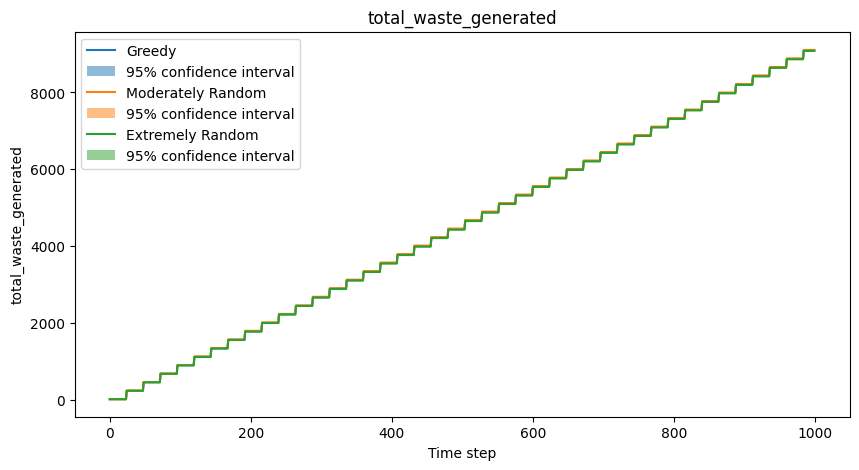

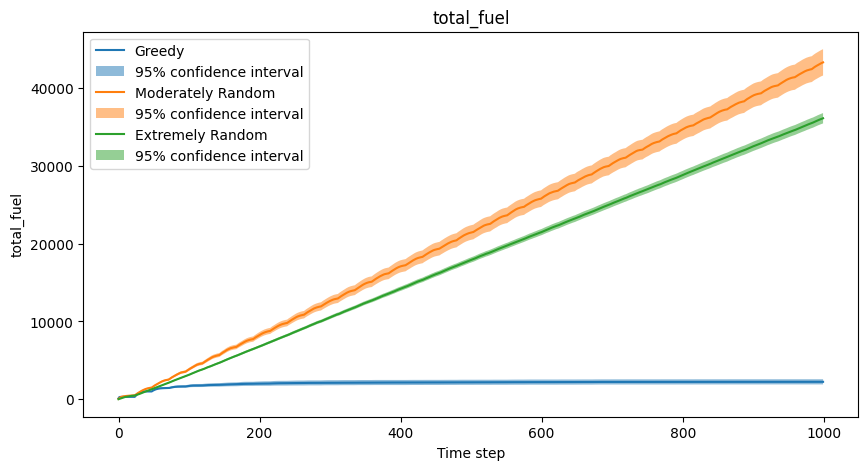

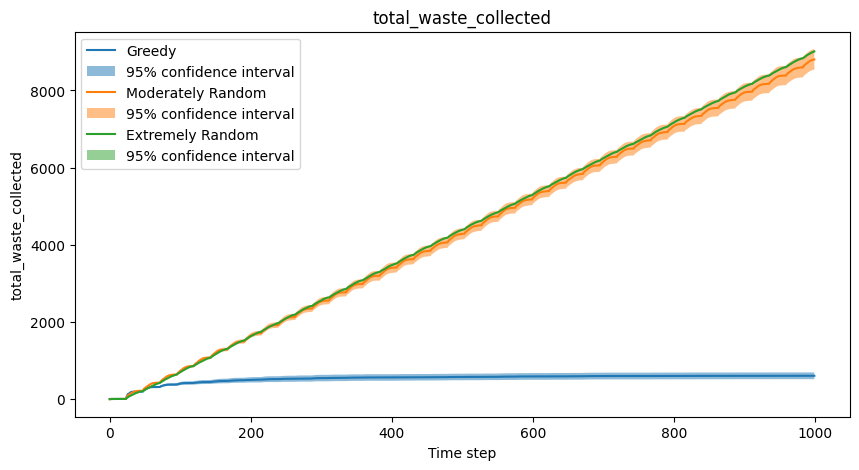

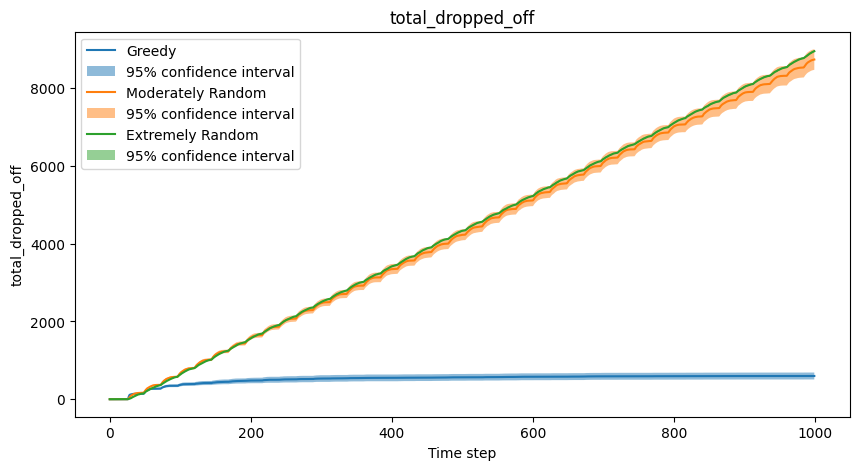

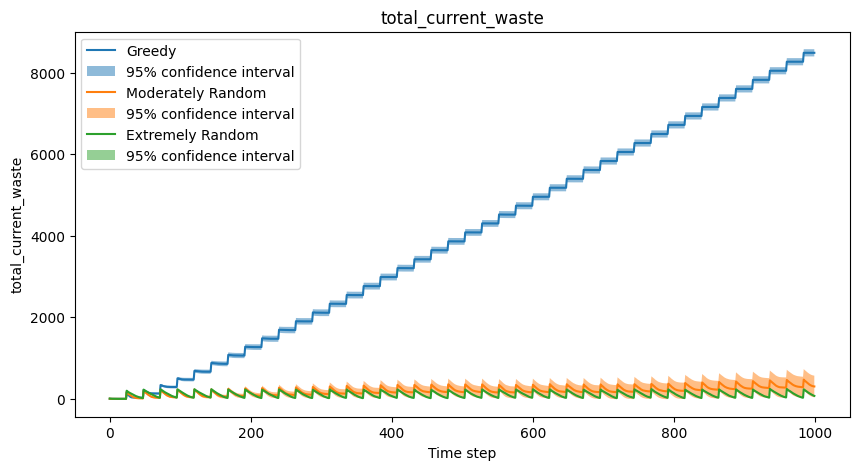

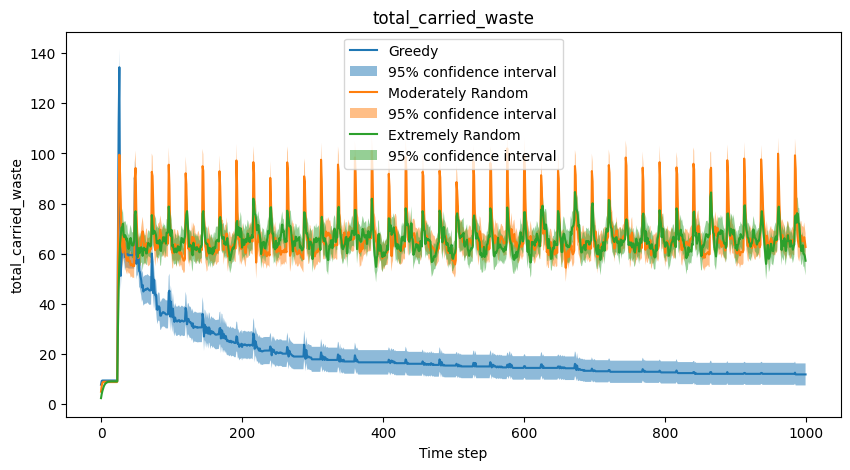

In [ ]:
# plot each metric for each strategy side-by-side

for d_m in greedy_overall_metrics.keys():

    plt.figure(figsize=(10, 5))
    plt.title(d_m)
    plt.xlabel('Time step')
    plt.ylabel(d_m)

    plt.plot(greedy_overall_metrics[d_m].keys(), [greedy_overall_metrics[d_m][i]['average'] for i in greedy_overall_metrics[d_m].keys()], label='Greedy')
    # fill between the upper and lower bound
    plt.fill_between(greedy_overall_metrics[d_m].keys(), [greedy_overall_metrics[d_m][i]['lower_bound'] for i in greedy_overall_metrics[d_m].keys()], [greedy_overall_metrics[d_m][i]['upper_bound'] for i in greedy_overall_metrics[d_m].keys()], alpha=0.5, label='95% confidence interval')

    plt.plot(moderately_random_metrics[d_m].keys(), [moderately_random_metrics[d_m][i]['average'] for i in moderately_random_metrics[d_m].keys()], label='Moderately Random')
    # fill between the upper and lower bound
    plt.fill_between(moderately_random_metrics[d_m].keys(), [moderately_random_metrics[d_m][i]['lower_bound'] for i in moderately_random_metrics[d_m].keys()], [moderately_random_metrics[d_m][i]['upper_bound'] for i in moderately_random_metrics[d_m].keys()], alpha=0.5, label='95% confidence interval')

    plt.plot(extremely_random_metrics[d_m].keys(), [extremely_random_metrics[d_m][i]['average'] for i in extremely_random_metrics[d_m].keys()], label='Extremely Random')
    # fill between the upper and lower bound
    plt.fill_between(extremely_random_metrics[d_m].keys(), [extremely_random_metrics[d_m][i]['lower_bound'] for i in extremely_random_metrics[d_m].keys()], [extremely_random_metrics[d_m][i]['upper_bound'] for i in extremely_random_metrics[d_m].keys()], alpha=0.5, label='95% confidence interval')



    plt.legend()
    plt.show()

In [ ]:
for dicti in [greedy_overall_metrics, moderately_random_metrics, extremely_random_metrics]:
    
    # Average carrying capacity
    avgs = []
    for trial in dicti['total_carried_waste']:
        avgs.append(dicti['total_carried_waste'][trial]['average'])
        
    print(35 - np.mean(avgs) / n_trucks)

31.160524
21.93215
22.147296


In [ ]:
for dicti in [greedy_overall_metrics, moderately_random_metrics, extremely_random_metrics]:
    
    # Average carrying capacity
    avgs = []
    for trial in dicti['total_current_waste']:
        avgs.append(dicti['total_current_waste'][trial]['average'])
        
    print(np.mean(avgs) / n_farms)

361.65266454545457
18.130465454545455
9.917113636363636


In [ ]:
trials = 100
theoretical_costs = []
empirical_costs = []

for t in range(trials):
    waste_sim = simulate_waste_system(steps=1000)
    waste_sim.theoretical_cost()
    theoretical_costs.append(waste_sim.estimated_waste)
    empirical_costs.append(waste_sim.empirical_cost(metric='waste'))


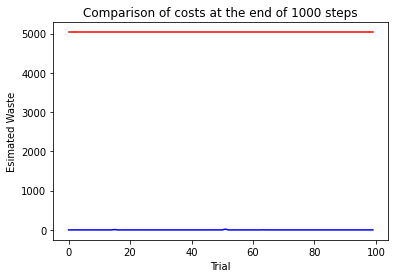

In [ ]:
plt.plot(theoretical_costs, label='theoretical', color='red')
plt.plot(empirical_costs, label='empirical', color='blue')
plt.xlabel('Trial')
plt.ylabel('Esimated Waste')
plt.title('Comparison of wastes at the end of 1000 steps')
plt.show()

### Simulating the System: Randomness Approach

In [ ]:
trials = 100
theoretical_costs = []
empirical_costs = []

for t in range(trials):
    waste_sim = simulate_waste_system(steps=1000, strategy='randomness')
    theoretical_costs.append(waste_sim.theoretical_cost())
    empirical_costs.append(waste_sim.empirical_cost())


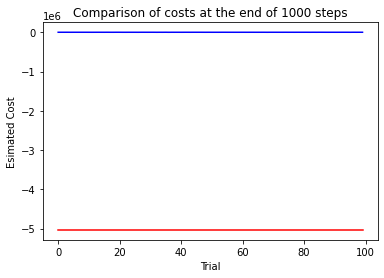

In [ ]:
plt.plot(theoretical_costs, label='theoretical', color='red')
plt.plot(empirical_costs, label='empirical', color='blue')
plt.xlabel('Trial')
plt.ylabel('Esimated Cost')
plt.title('Comparison of costs at the end of 1000 steps')
plt.show()

In [ ]:
trials = 100
theoretical_costs = []
empirical_costs = []

for t in range(trials):
    waste_sim = simulate_waste_system(steps=1000)
    waste_sim.theoretical_cost()
    theoretical_costs.append(waste_sim.estimated_waste)
    empirical_costs.append(waste_sim.empirical_cost(metric='waste'))


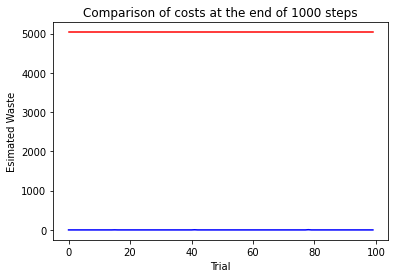

In [ ]:
plt.plot(theoretical_costs, label='theoretical', color='red')
plt.plot(empirical_costs, label='empirical', color='blue')
plt.xlabel('Trial')
plt.ylabel('Esimated Waste')
plt.title('Comparison of costs at the end of 1000 steps')
plt.show()

### Comparison of the two approaches

In [ ]:
greedy_costs = []
random_costs = []

trials = 50

for t in range(trials):
    greedy_simulation = simulate_waste_system(steps=100)
    random_simulation = simulate_waste_system(steps=100, strategy='randomness')
    greedy_costs.append(greedy_simulation)
    random_costs.append(random_simulation)

AttributeError: 'list' object has no attribute 'costs'

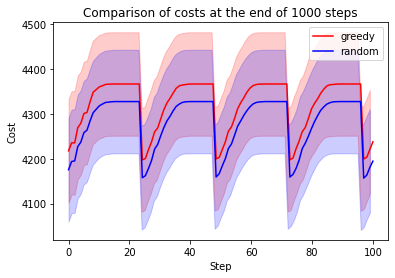

In [ ]:
# find the average cost for each step
greedy_stuff = [ np.mean([g.costs[i] for g in greedy_costs]) for i in range(100) ]
random_stuff = [ np.mean([r.costs[i] for r in random_costs]) for i in range(100) ]

# find the confidence interval for each step
greedy_std = np.std(greedy_stuff, axis=0)
random_std = np.std(random_stuff, axis=0)

greedy_lower_bound = greedy_stuff - greedy_std * 1.96   
greedy_upper_bound = greedy_stuff + greedy_std * 1.96

random_lower_bound = random_stuff - random_std * 1.96
random_upper_bound = random_stuff + random_std * 1.96

plt.plot(np.linspace(0, 100, 100), greedy_stuff, label='greedy', color='red')
plt.plot(np.linspace(0, 100, 100), random_stuff, label='random', color='blue')
plt.fill_between(range(len(greedy_stuff)), greedy_lower_bound, greedy_upper_bound, color='red', alpha=0.2)
plt.fill_between(range(len(random_stuff)), random_lower_bound, random_upper_bound, color='blue', alpha=0.2)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Comparison of costs at the end of 1000 steps')
plt.legend()
plt.show()


In [ ]:
# find the average cost for each step
# find the total waste generated by each farm 
greedy_wastes = 0
for simulation in greedy_costs:
    waste_generated = 0
    for farm in simulation.farms:
        waste_generated += farm.waste_generated

    greedy_wastes += waste_generated

random_wastes = 0
for simulation in random_costs:
    waste_generated = 0
    for farm in simulation.farms:
        waste_generated += farm.waste_generated

    random_wastes += waste_generated



plt.hist(greedy_costs, label='greedy', color='red')
plt.hist(random_costs, label='random', color='blue')
plt.fill_between(range(len(greedy_costs)), greedy_lower_bound, greedy_upper_bound, color='red', alpha=0.2)
plt.fill_between(range(len(random_costs)), random_lower_bound, random_upper_bound, color='blue', alpha=0.2)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Comparison of waste at the end of 1000 steps')
plt.show()
